# Create Demo Data for Jail

##  Create fake jail data

To create fake PII data, we use the source code from socrates for simulation: https://github.com/Lattice-Works/Socrates-dev/tree/master/resources

(install both butter-fingers and simulator, and a few other dependencies as needed)

In [30]:
from participantgenerator.tablegenerator import subjectgenerator
from flighttools import flight, visuals
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import openlattice
import sqlalchemy
import uuid
import os

In [31]:
jwt = ""

In [32]:
basedir = "/Users/jokedurnez/Documents/Integrations/FakeIntegrations/DemoData/"
imdir = "/Users/jokedurnez/Documents/Integrations/FakeIntegrations/DemoData/graphs/"

baseurl = 'https://api.openlattice.com'

configuration = openlattice.Configuration()
configuration.host = baseurl
configuration.api_key_prefix['Authorization'] = 'Bearer'
configuration.api_key['Authorization'] = jwt

orgApi = openlattice.OrganizationsApi(openlattice.ApiClient(configuration))
dataApi = openlattice.DataApi(openlattice.ApiClient(configuration))
permissionsApi = openlattice.PermissionsApi(openlattice.ApiClient(configuration))
edmApi = openlattice.EdmApi(openlattice.ApiClient(configuration))

In [33]:
demoflightfile = os.path.join(basedir,'demo_jail.yaml')
demodatafile = os.path.join(basedir, "demo_jail.csv")

Define probabilities in demodata

In [34]:
typoness = {
    "firstName": 0.01,
    "middleName": 0.01,
    "lastName": 0.01,
    "ssn": 0,
    "sex": 0.01,
    "dob": 0,
    "race": 0.0,
    "ethnicity": 0.0        
}
missingness = {
    "firstName": 0,
    "middleName": 0,
    "lastName": 0,
    "ssn": 0.1,
    "sex": 0.1,
    "dob": 0,
    "race": 0.1,
    "ethnicity": 0.1
}

# from 2018 census
education_dict = {
    "Elementary or High school, no diploma": 14.2/100,
    "9th grade, no diploma": 7./100,
    "10th grade, no diploma": 7./100,
    "11th grade, no diploma": 7./100,
    "12th grade, no diploma": 4.4/100,
    'Elementary or High school, GED': 28.5/100,
    'High school diploma': 20.5/100,
    "Postsecondary": 11.4/100
}

# based on customer probabilities > 0.01
reason_dict = {
    'OFA': 0.27,
    'WFA': 0.25,
    'VIEW': 0.17,
    'MO': 0.16,
    'CO': 0.05,
    'PR': 0.03,
    'WRIT': 0.02,
    'BS': 0.01,
    'CIT': 0.01,
    'SENT': 0.01,
    'SWK': 0.01,
    'TC': 0.01}

facility_dict = {
    "SomeJail": 0.25,
    "AnyJail": 0.25,
    "AnotherJail": 0.25,
    "CountyJail": 0.25
}

gender_dict = {
    'Male': 0.650, 
    "Female": 0.1, 
    "Non-Binary": 0.02, 
    "Transgender (Male to Female)": 0.02, 
    "Transgender (Female to Male)": 0.02, 
    "Other": 0.03, 
    "Unknown": 0.02, 
    "Decline to State": 0.12, 
    "Not Asked":0.02
}

marital_dict = {
    'Single': 0.3 , 
    'Married': 0.3, 
    'Widowed': 0.1, 
    'Separated': 0.05, 
    'Divorced': 0.15, 
    'Domestic Partner': 0.05, 
    'Common Law': 0.05
}

In [6]:
# function to get a random date in a predefined year
def random_date_in_year(year):
    startyear = datetime.strptime('1/1/%s 00:00'%year, '%m/%d/%Y %H:%M')
    secondsinyear = 365*24*60*60
    seconds_from_newyear = np.random.randint(low = 0, high = secondsinyear)
    date = startyear + timedelta(seconds = seconds_from_newyear)
    return date

Actually simulate data

In [7]:
dfdict = []

for i in range(20000):
    # generate person
    subject = subjectgenerator.subject()
    subject.generate()
    variant = subject.create_variant(typoness, missingness,0 ,0)
    variant['education'] = np.random.choice(list(education_dict.keys()), p = list(education_dict.values()))
    variant['name_id'] = str(uuid.uuid1())
    variant['gender'] = np.random.choice(list(gender_dict.keys()), p = list(gender_dict.values()))

    # helper variables
    bkyear = np.random.randint(low = 12, high = 19)
    bkdate = random_date_in_year(2000+bkyear)
    sentencelengthdays = np.random.randint(low = 0, high = 15*365)
    reldate = bkdate + timedelta(days = sentencelengthdays)
    ageatbooking = int((bkdate - datetime.strptime(variant['dob'], "%Y-%m-%d")).days/365)

    # generate jailstay
    variant['book_id'] = bkyear + np.random.randint(low = 10000, high = 99999)
    variant['bkstatus'] = np.random.choice(['I', 'A'], p = [0.9, 0.1])
    variant['bookDateTime'] = bkdate.strftime('%m/%d/%Y %H:%M')
    variant['confreason'] = np.random.choice(list(reason_dict.keys()), p = list(reason_dict.values()))
    variant['releasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M') if reldate < datetime.now() else None
    variant['projectedreleasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M')

    # generate jailstaylength
    variant['daysserved'] = sentencelengthdays

    # generate facilities
    variant['facility'] = np.random.choice(list(facility_dict.keys()), p = list(facility_dict.values()))

    # generate hearings
    variant['docketno'] = str(bkyear)+"CR"+str(np.random.randint(low = 10000, high = 99999))

    # generate persondetails
    variant['maritalstatus'] =  np.random.choice(list(marital_dict.keys()), p = list(marital_dict.values())) \
        if ageatbooking > 20 else "Single"
    variant['juvenile'] = "Y" if ageatbooking < 18 else "N"
    
    # generate persondetails sexoffender
    variant['sexoffender'] = np.random.choice(["Y", "N"], p = [0.4, 0.6]) if \
        ageatbooking > 20 else np.random.choice(["Y", "N"], p = [0.4, 0.6])
    
    dfdict.append(variant)

In [8]:
demodata = pd.DataFrame(dfdict)
demodata.head()

,firstName,lastName,middleName,sex,ssn,dob,race,ethnicity,education,name_id,...,bookDateTime,confreason,releasedatetime,projectedreleasedatetime,daysserved,facility,docketno,maritalstatus,juvenile,sexoffender
0,Lenny,Stanger,N,M,867-51-0811,2007-04-18,Declined,Non-Hispanic,High school diploma,cae4fccc-3d47-11ea-ae91-8c85902f5161,...,08/04/2016 19:48,SWK,02/21/2019 19:48,02/21/2019 19:48,931,AnotherJail,16CR42218,Single,Y,Y
1,Kevin,Dagis,P,F,,1955-05-19,White,Non-Hispanic,"Elementary or High school, no diploma",cae84cb4-3d47-11ea-a22f-8c85902f5161,...,02/21/2012 12:37,OFA,None,07/13/2022 12:37,3795,SomeJail,12CR18770,Divorced,N,N
2,Dmnald,Chappell,T,F,777-70-4346,1936-08-07,,Unknown,"9th grade, no diploma",cae9c8d0-3d47-11ea-96b2-8c85902f5161,...,09/12/2015 20:26,OFA,None,01/31/2021 20:26,1968,SomeJail,15CR34125,Married,N,N
3,Marie,Terrell,K,F,,1954-03-09,White,Hispanic,Postsecondary,caf2be4a-3d47-11ea-9c77-8c85902f5161,...,04/27/2017 11:52,OFA,04/21/2018 11:52,04/21/2018 11:52,359,SomeJail,17CR49314,Divorced,N,N
4,Billy,Taylor,S,F,715-16-0752,1942-12-23,White,Hispanic,"Elementary or High school, no diploma",caf41718-3d47-11ea-bb25-8c85902f5161,...,08/19/2012 12:46,WFA,None,07/14/2022 12:46,3616,SomeJail,12CR97796,Single,N,N


In [9]:
demodata.to_csv(demodatafile)

## Create vizzies

In [35]:
fl = flight.flight(edmAPI=edmApi)
fl.deserialise(demoflightfile)
fl.add_and_check_edm()

Checking property types for association types...
Checking property types for entity types...
Checking entity types in edges...


/Users/jokedurnez/anaconda3/lib/python3.6/site-packages/flighttools-0.0.1-py3.6.egg/flighttools/visuals.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  aesth = yaml.load(infile)


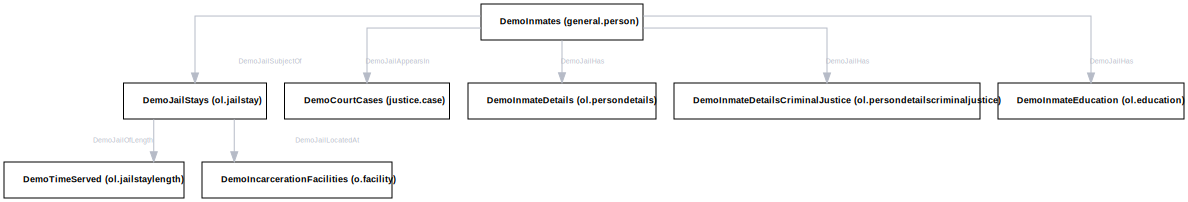

In [36]:
visualisation = visuals.edmViz(flight = fl, engine = "dot", splines = "ortho",
                               aesthetics = {
                                   'entityDefinitions': {
                                       'style': 'square',
                                       'color': 'black',
                                       'fontcolor': 'black',
                                       'titlefontcolor': 'black'
                                   },
                                   'associationDefinitions': {
                                       'color': '#B6BBC7',
                                       'fontcolor': '#B6BBC7'
                               }
                               }
                                   )
tiny = visualisation.create_flight_plot(type="entityset_name")
tiny.format = 'png'
tiny.render(os.path.join(imdir, "demojail_graph"))
tiny

/Users/jokedurnez/anaconda3/lib/python3.6/site-packages/flighttools-0.0.1-py3.6.egg/flighttools/visuals.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  aesth = yaml.load(infile)


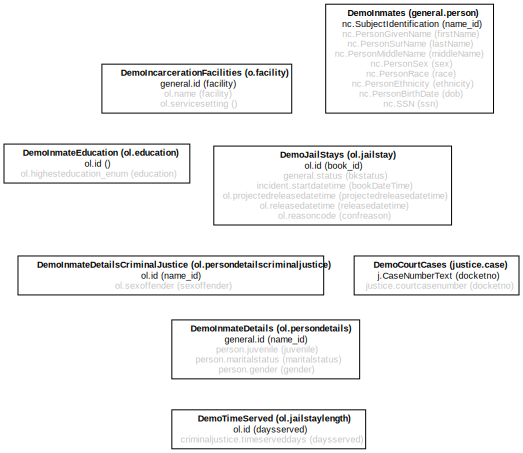

In [37]:
visualisation = visuals.edmViz(flight = fl, engine = "circo", splines = "ortho",
                               aesthetics = {
                                   'entityDefinitions': {
                                       'style': 'square',
                                       'color': 'black',
                                       'fontcolor': 'black',
                                       'titlefontcolor': 'black'
                                   },
                                   'associationDefinitions': {
                                       'color': '#B6BBC7',
                                       'fontcolor': '#B6BBC7'
                               }
                               }
                                   )

vb = visualisation.create_flight_plot(type="entityset_name", fields = ["properties"], plotlinks=False)
vb.format = 'png'
vb.render(os.path.join(imdir, "demojail_fields"))
vb

In [38]:
cols_fl = fl.get_all_columns()

In [14]:
cols_df = set(demodata.columns)

In [15]:
cols_df - cols_fl

set()

In [16]:
cols_fl - cols_df

set()

## Create entity sets

In [39]:
demo_org_id = '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8'

In [40]:
entitysets = fl.get_all_entitysets(
        remove_prefix= "Demo", 
        add_prefix="Demo Jail: ", 
        add_suffix = "",
        contacts= ['kim@openlattice.com', 'joke@openlattice.com']
    )

In [41]:
entsets = []
for entityset in entitysets:
    entset = openlattice.EntitySet(
        entity_type_id = entityset['entityTypeId'],
        name = entityset['name'],
        title = entityset['title'],
        description = entityset['title'],
        contacts = entityset['contacts'],
        organization_id = demo_org_id
    )
    entsets.append(entset)

In [20]:
# once is good enough :-)
# edmApi.create_entity_sets(entsets)

## Permissions

In [42]:
roles = orgApi.get_organization(demo_org_id).roles
roles = [x.principal for x in roles if "DemoData" in x.title]
roles

[{'id': '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8|DemoData_Write', 'type': 'ROLE'},
 {'id': '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8|DemoData_Read', 'type': 'ROLE'},
 {'id': '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8|DemoData_Owner', 'type': 'ROLE'}]

In [46]:
for entityset in entsets:
    print(" -- granting permissions on %s: "%entityset.name, end = "")
    entitysetid = edmApi.get_entity_set_id(entityset.name)
    properties = edmApi.get_entity_type(entityset.entity_type_id).properties
    for role in roles:
        
        permission = role.id.split("DemoData_")[1].upper()
        print(permission, end = "-")
        
        # create access controly entry (ACE) for user
        ace = openlattice.Ace(
            principal = role,
            permissions = [permission]
        )

        # create acldata for the entityset: 
        # link the access control list (ACL) of the entityset
        # to the ACE of the user
        acldata = openlattice.AclData(action = "ADD",
                            acl = openlattice.Acl(acl_key = [entitysetid],aces = [ace]))
        permissionsApi.update_acl(acldata)

        # do the same for the ACL's of all properties in the entityset
        for propertytypeid in properties:
            acldata = openlattice.AclData(action = "ADD",
                                acl = openlattice.Acl(acl_key = [entitysetid, propertytypeid],aces = [ace]))
            permissionsApi.update_acl(acldata)
    print("", end = "\n")

 -- granting permissions on DemoInmates: WRITE-READ-OWNER-
 -- granting permissions on DemoJailStays: WRITE-READ-OWNER-
 -- granting permissions on DemoTimeServed: WRITE-READ-OWNER-
 -- granting permissions on DemoIncarcerationFacilities: WRITE-READ-OWNER-
 -- granting permissions on DemoCourtCases: WRITE-READ-OWNER-
 -- granting permissions on DemoInmateDetails: WRITE-READ-OWNER-
 -- granting permissions on DemoInmateDetailsCriminalJustice: WRITE-READ-OWNER-
 -- granting permissions on DemoInmateEducation: WRITE-READ-OWNER-
 -- granting permissions on DemoJailSubjectOf: WRITE-READ-OWNER-
 -- granting permissions on DemoJailLocatedAt: WRITE-READ-OWNER-
 -- granting permissions on DemoJailAppearsIn: WRITE-READ-OWNER-
 -- granting permissions on DemoJailHas: WRITE-READ-OWNER-
 -- granting permissions on DemoJailOfLength: WRITE-READ-OWNER-


In [28]:
{edmApi.get_entity_set_id(x.name): x.name for x in entsets}

{'7cdd42d7-b2a7-4a4d-b934-115a1e7ddd86': 'DemoInmates',
 'c66072a3-eb77-4a19-a198-8a9e6fc2eed2': 'DemoJailStays',
 '73cdfd4e-3c95-401b-a83a-a091695381d5': 'DemoTimeServed',
 'c55ea9a3-8027-45f3-a912-89dd07e7d8a9': 'DemoIncarcerationFacilities',
 'b2aebc55-5a63-476e-bb5e-6bb910080032': 'DemoCourtCases',
 '90c5299e-93b0-459c-a846-4080a10321ce': 'DemoInmateDetails',
 '50b85b58-1b85-4c1f-ac0c-7966ad3806d6': 'DemoInmateDetailsCriminalJustice',
 'e23cca71-3225-4f6a-8f31-2c8713267471': 'DemoInmateEducation',
 '8df986b9-4ce3-41cb-86ed-090eb6d10dbb': 'DemoJailSubjectOf',
 'c7998615-3c00-422d-8a4f-8218b9fccbd7': 'DemoJailLocatedAt',
 '9fe85a51-6986-43dd-af0f-89eff69665da': 'DemoJailAppearsIn',
 '962cb4bb-3b9a-4e7e-aa01-d257094e2cc5': 'DemoJailHas',
 'e8d64c0a-618a-4169-825e-43b2721e6cf7': 'DemoJailOfLength'}

In [ ]:
shuttle = os.path.join(
    "/Users/jokedurnez/Documents/openlattice/shuttle/",
    "shuttle-0.0.4-SNAPSHOT/bin/shuttle"
)

statement = "{shuttle} --flight {flight} --token {token} --csv \"{csv}\" --environment  {local} ".format(
    shuttle = shuttle,
    flight = demoflightfile,
    token = jwt,
    csv = demodatafile,
    local = "PROD_INTEGRATION"
)
    
# print(statement)

In [ ]:
# dataApi.load_entity_set_data(edmAPI.get_entity_set_id("DemoInmates"))